In [100]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import lightgbm
import xgboost as xgb

In [99]:
# read in (yaml) configs
with open('../conf/model_config.yaml', 'r') as conf:
    model_config = yaml.safe_load(conf)

# import data
dataset = '../' + model_config['model']['loc'] + model_config['model']['file']
dataset = pd.read_csv(dataset)

# define predictors and target
predictor = model_config['meta']['predictors']
target = model_config['meta']['target']

In [42]:
X = dataset[predictor]
y = dataset[target]
print('X Shape:', X.shape)
print('y Shape:', y.shape)
   
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = model_config['parameter']['test_size'], random_state = 42)

X Shape: (373296, 52)
y Shape: (373296, 1)


In [43]:
print('X_train, X_test, y_train, y_test shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Size of training dataset = ", len(X_train))
print("Size of test dataset = ", len(X_test))

X_train, X_test, y_train, y_test shapes: (261307, 52) (111989, 52) (261307, 1) (111989, 1)
Size of training dataset =  261307
Size of test dataset =  111989


# LightGBM Mean Test Score 88.0%

In [44]:
pipe = Pipeline([
('scaler', StandardScaler()),
('selector', VarianceThreshold()),
('classifier', lightgbm.LGBMRegressor(random_state=42))
])
 
pipe.fit(X_train, y_train)
 
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

C:\Users\ucn\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training set score: 0.9106947698211935
Test set score: 0.9356190238422595


In [46]:
parameters = {'scaler': [StandardScaler()],
	'selector__threshold': [0, 0.001, 0.01],
	'classifier__boosting_type': model_config['parameter']['lightgbm']['boosting_type'],
	'classifier__max_depth': model_config['parameter']['lightgbm']['max_depth'],
	'classifier__learning_rate': model_config['parameter']['lightgbm']['learning_rate'],
    'classifier__n_estimators': model_config['parameter']['lightgbm']['n_estimators']
}

In [51]:
# configure cv
cv_inner = KFold(n_splits = model_config['parameter']['inner_cv'], shuffle=True, random_state=42)

grid = GridSearchCV(pipe, 
                    parameters, 
                    cv=cv_inner, 
                    refit = True,
                    verbose = 2)

result = grid.fit(X_train, y_train.values.ravel())
 
print('Training set score: ' + str(result.score(X_train, y_train)))
print('Test set score: ' + str(result.score(X_test, y_test)))

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] END classifier__boosting_type=dart, classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=50, scaler=StandardScaler(), selector__threshold=0; total time=   3.6s
[CV] END classifier__boosting_type=dart, classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=50, scaler=StandardScaler(), selector__threshold=0; total time=   2.9s
[CV] END classifier__boosting_type=dart, classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=50, scaler=StandardScaler(), selector__threshold=0; total time=   3.0s
[CV] END classifier__boosting_type=dart, classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=50, scaler=StandardScaler(), selector__threshold=0.001; total time=   2.9s
[CV] END classifier__boosting_type=dart, classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=50, scaler=StandardScaler(), 

In [52]:
# Access the best set of parameters
best_params = result.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = result.best_estimator_
print(best_pipe)

{'classifier__boosting_type': 'dart', 'classifier__learning_rate': 0.2, 'classifier__max_depth': -1, 'classifier__n_estimators': 500, 'scaler': StandardScaler(), 'selector__threshold': 0}
Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('classifier',
                 LGBMRegressor(boosting_type='dart', learning_rate=0.2,
                               n_estimators=500, random_state=42))])


In [53]:
result_df = pd.DataFrame.from_dict(result.cv_results_, orient='columns')
print(result_df.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__boosting_type', 'param_classifier__learning_rate',
       'param_classifier__max_depth', 'param_classifier__n_estimators',
       'param_scaler', 'param_selector__threshold', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


In [83]:
result_df.sort_values(by='mean_test_score', ascending=False)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__boosting_type,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_scaler,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
153,135.798539,15.823459,2.159826,0.361277,dart,0.2,-1,500,StandardScaler(),0,"{'classifier__boosting_type': 'dart', 'classif...",0.767078,0.955919,0.919294,0.880764,0.081767,1
155,250.176710,27.152674,5.773648,2.620583,dart,0.2,-1,500,StandardScaler(),0.01,"{'classifier__boosting_type': 'dart', 'classif...",0.767078,0.955919,0.919294,0.880764,0.081767,1
154,269.244508,35.252913,3.599120,0.243573,dart,0.2,-1,500,StandardScaler(),0.001,"{'classifier__boosting_type': 'dart', 'classif...",0.767078,0.955919,0.919294,0.880764,0.081767,1
191,123.386861,2.340999,2.157130,0.028598,dart,0.2,20,500,StandardScaler(),0.01,"{'classifier__boosting_type': 'dart', 'classif...",0.767078,0.955879,0.919294,0.880750,0.081754,4
190,122.277421,7.355904,2.202903,0.208113,dart,0.2,20,500,StandardScaler(),0.001,"{'classifier__boosting_type': 'dart', 'classif...",0.767078,0.955879,0.919294,0.880750,0.081754,4
189,176.799341,10.376322,2.379683,0.201277,dart,0.2,20,500,StandardScaler(),0,"{'classifier__boosting_type': 'dart', 'classif...",0.767078,0.955879,0.919294,0.880750,0.081754,4
177,94.141828,0.695127,1.671318,0.091827,dart,0.2,10,500,StandardScaler(),0,"{'classifier__boosting_type': 'dart', 'classif...",0.766556,0.955953,0.918896,0.880468,0.081957,7
178,91.737412,0.662475,1.611127,0.026061,dart,0.2,10,500,StandardScaler(),0.001,"{'classifier__boosting_type': 'dart', 'classif...",0.766556,0.955953,0.918896,0.880468,0.081957,7
179,92.151233,1.679561,1.622129,0.038015,dart,0.2,10,500,StandardScaler(),0.01,"{'classifier__boosting_type': 'dart', 'classif...",0.766556,0.955953,0.918896,0.880468,0.081957,7
165,74.283412,10.076412,1.516730,0.065998,dart,0.2,5,500,StandardScaler(),0,"{'classifier__boosting_type': 'dart', 'classif...",0.765672,0.955927,0.919633,0.880411,0.082475,10


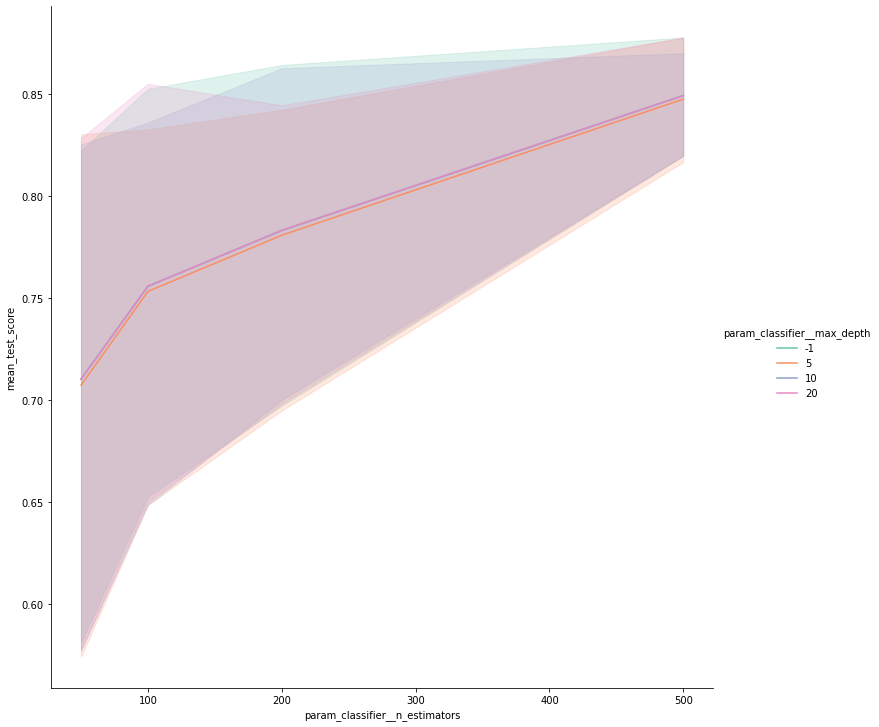

In [87]:
sns.relplot(data=result_df,
	kind='line',
	x='param_classifier__n_estimators',
	y='mean_test_score',
	hue='param_classifier__max_depth',
	palette='Set2', height=10)
plt.show()

# XGBoost Mean Test Score 94.5%

In [90]:
pipe_xgb = Pipeline([('scaler', StandardScaler()), ('regressor', xgb.XGBRegressor(random_state=42))])
 
pipe_xgb.fit(X_train, y_train)
 
print('Training set score: ' + str(pipe_xgb.score(X_train,y_train)))
print('Test set score: ' + str(pipe_xgb.score(X_test,y_test)))

Training set score: 0.999962589953964
Test set score: 0.9802433788852499


In [94]:
parameters_xgb = {'scaler': [StandardScaler()],
	'regressor__max_depth': model_config['parameter']['XGBoost']['max_depth'],
	'regressor__eta': model_config['parameter']['XGBoost']['eta'],
    'regressor__n_estimators': model_config['parameter']['XGBoost']['n_estimators']
}

In [95]:
grid_xgb = GridSearchCV(pipe_xgb, 
                        parameters_xgb, 
                        cv=cv_inner, 
                        refit = True,
                        verbose = 2)

result_xgb = grid_xgb.fit(X_train, y_train.values.ravel())
 
print('Training set score: ' + str(result_xgb.score(X_train, y_train)))
print('Test set score: ' + str(result_xgb.score(X_test, y_test)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=100, scaler=StandardScaler(); total time=  11.8s
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=100, scaler=StandardScaler(); total time=  12.3s
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=100, scaler=StandardScaler(); total time=  12.7s
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=300, scaler=StandardScaler(); total time=  38.1s
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=300, scaler=StandardScaler(); total time=  38.6s
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=300, scaler=StandardScaler(); total time=  36.3s
[CV] END regressor__eta=0.05, regressor__max_depth=3, regressor__n_estimators=500, scaler=StandardScaler(); total time=  59.7s
[CV] END regressor__eta=0.05, regressor__max_dept

In [96]:
# Access the best set of parameters
best_params_xgb = result_xgb.best_params_
print(best_params_xgb)
# Stores the optimum model in best_pipe
best_pipe_xgb = result_xgb.best_estimator_
print(best_pipe_xgb)

{'regressor__eta': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'scaler': StandardScaler()}
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, eta=0.05, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=3, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=0, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_p

In [97]:
result_df_xgb = pd.DataFrame.from_dict(result_xgb.cv_results_, orient='columns')
print(result_df_xgb.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__eta', 'param_regressor__max_depth',
       'param_regressor__n_estimators', 'param_scaler', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


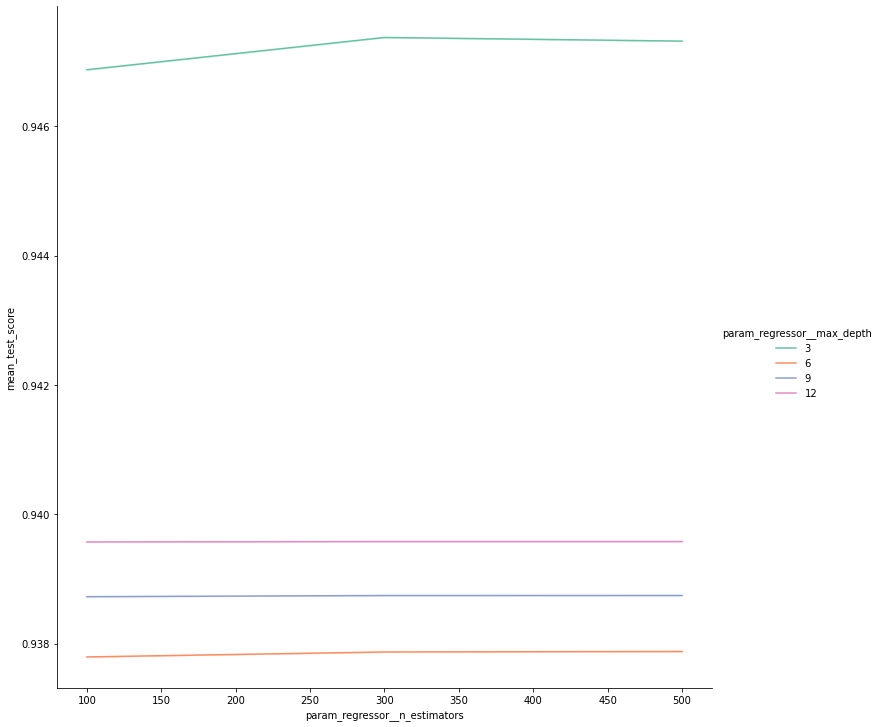

In [98]:
sns.relplot(data=result_df_xgb,
	kind='line',
	x='param_regressor__n_estimators',
	y='mean_test_score',
	hue='param_regressor__max_depth',
	palette='Set2', height=10)
plt.show()

# SVM

In [ ]:
pipe_svm = Pipeline([('scaler', StandardScaler()), ('regressor', svm.SVR())])
 
pipe_svm.fit(X_train, y_train)
 
print('Training set score: ' + str(pipe_svm.score(X_train,y_train.values.ravel())))
print('Test set score: ' + str(pipe_svm.score(X_test,y_test.values.ravel())))

In [ ]:
parameters_svm = {'scaler': [StandardScaler()],
	'regressor__C': model_config['parameter']['svm']['C'],
	'regressor__gamma': model_config['parameter']['svm']['gamma'],
    'regressor_kernel': model_config['parameter']['svm']['kernel']
}

In [ ]:
grid_svm = GridSearchCV(pipe_svm, 
                        parameters_svm, 
                        cv=cv_inner, 
                        refit = True,
                        verbose = 2)

result_svm = grid_svm.fit(X_train, y_train.values.ravel())
 
print('Training set score: ' + str(result_svm.score(X_train, y_train)))
print('Test set score: ' + str(result_svm.score(X_test, y_test)))